# Go-ZT train final model
### This notebook contains the code need to train the final DNN using [0,1,2] encoded summary toxicity matrices and chemicals structural data.
#### See http://biorxiv.org/lookup/doi/10.1101/2020.10.02.322917 for details

By Adrian J Green, PhD

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"           # Only one GPU will be seen

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import multi_gpu_model

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print("tensorflow version",tf.__version__,". Executing eagerly?",tf.executing_eagerly())

# minimize GPU useage by allowing memeory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
print("\nNumber of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version 2.1.0 . Executing eagerly? True
1 Physical GPUs, 1 Logical GPUs

Number of GPUs:  1


In [2]:
# standard python
import numpy as np
import pathlib
import collections
import warnings

# plotting, especially for jupyter notebooks
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image

# pandas
import pandas as pd

# local routines
from chemdataprep import load_PDBs
from toxmathandler_AG import load_tmats

# NN build routines
from NNbuild_train_vis import init_generator

# NN train routines
from NNbuild_train_vis import write_training_file

# Performance evaluation routines
from gen_AggE import calc_AggE, display_conf_matrix

In [3]:
# Global data options

### PDB options

# cGAN & views parameters
# [Gfeatures,Gbaselayers,Glayers,Dfeatures,Dbaselayers,Dlayers,carbonbased, setNatoms, views, ClassLabels]
parameters = [279, 3, 11, 18, 0, 0, False, 82, 126, None] # Go-ZT

## Option to base views on carbon or not. (Safe even if some have no carbon.)
# Setting True will make the data smaller in memory and everything run faster.
carbonbased = parameters[6]
## Option for truncating the length of views.
# Truncating will make the data and NN smaller and things run faster.
# It make sense if we believe that looking at all neighborhoods of some size 
# gives sufficient understanding of the chemical.
# setNatoms = None # use max number in data
setNatoms = parameters[7] # truncate to this number
parameters[9] = None # allow cGAN to use class labels in training, None or int

if carbonbased:
    views = None
else:
    views=parameters[8]

dataType = '(0,1)_18x1'

# Traning individual toxic
allpath = '/home2/ajgreen4/Read-Across_w_GAN/DataFiles/(0,1,2)_encoding/tox21_all_compounds/'
    
modelpath = '/home2/ajgreen4/Read-Across_w_GAN/Models/Go-ZT/'
dataType = '(0,1)_18x1'
genPrefix = 'AG-model-regGT-'+dataType

# Data Preparation

* We may want more info, such as a charge, to be included

In [4]:
# load all files files
[ws, vs, Natoms, Nviews, chemnames, Vshape] = load_PDBs(allpath,setNatoms=setNatoms,setNviews=views, carbonbased=carbonbased)

1003 pdb files found at /home2/ajgreen4/Read-Across_w_GAN/DataFiles/(0,1,2)_encoding/tox21_all_compounds/PDBs/
Species occurring = {'H', 'CL', 'N', 'BR', 'P', 'I', 'B', 'SI', 'AS', 'O', 'F', 'S', 'C'}
Setting all views to Natoms= 82
126 views needed, but setting to 126
Maximum views used = 126
Data tensor (w,v) shapes= (1003, 126) (1003, 126, 410)


In [5]:
# outputs/labels

print("Using toxicity matrix as labels")
### Toxicity matrix options
if (genPrefix.find('(0,1)_18x6')!=-1):
    concentrations = [0,1,2,3,4,5]
else:
    concentrations = [-1]    ## Which of the available endpoints to use
endpoints = [i for i in range(4,22)] # use all

# load validation files
[toxicity, rows, cols, fish] = load_tmats(allpath,chemnames, 
                                                         concentration_indexes=concentrations, 
                                                         endpoint_indexes=endpoints,transform=True,
                                                         SET=3,verbose=1)

# legend labels for plotting
endpoints = [i for i in range(len(rows))]
concentrations = [i for i in range(len(cols))]
print("Using", len(concentrations), "concentrations")
print("Using", len(endpoints), "endpoints")
legend = [rows,cols,endpoints,concentrations]

Using toxicity matrix as labels
Transforming encoding to [no effect,effect or NA (dead)]=[0,1].
Number of chemicals= 1003
Using concentrations ['64 uM']
Using endpoints: ['MORT', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', 'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC', 'TRUN', 'SWIM', 'NC__', 'TR__']
Toxicity vector length Ntoxicity= 18
Using 1 concentrations
Using 18 endpoints


# Neural Network code

### Fitting generator with conventional regression

This tests if G has enough power to get the truth, how fast it could learn, etc

In [6]:
# losses
Gloss_function = tf.keras.losses.MeanSquaredError()

# optimizers
generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

generator = init_generator([ws, vs],toxicity,parameters)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
parallelwrapper_input0 (InputLa [(None, 126, 410)]   0                                            
__________________________________________________________________________________________________
Gbase (Model)                   (None, 126, 279)     1428021     parallelwrapper_input0[0][0]     
__________________________________________________________________________________________________
parallelScalars (InputLayer)    [(None, 126)]        0                                            
__________________________________________________________________________________________________
weighted_sum_over_views (Dot)   (None, 279)          0           Gbase[1][0]                      
                                                                 parallelScalars[0][0]    

In [7]:
%%time
# fit
BATCH_SIZE = 201
history = generator.fit([ws, vs],toxicity,
              epochs=75,batch_size=BATCH_SIZE,verbose=0)
training_loss = round(generator.evaluate([ws, vs],toxicity,verbose=0), 4)

CPU times: user 29.4 s, sys: 35.8 s, total: 1min 5s
Wall time: 41.4 s


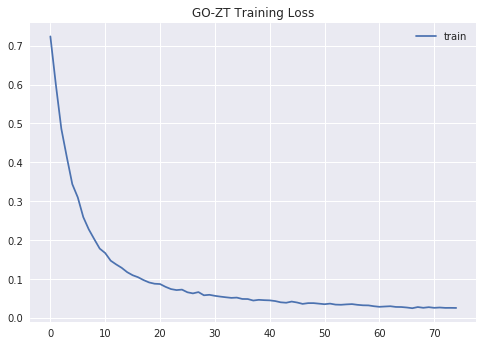

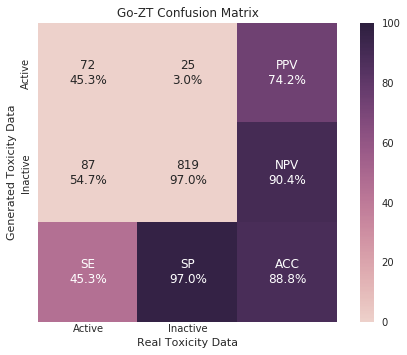



Kappa:  0.503
Auroc:  0.7116


In [15]:
# Plot figures
if 1:
    # plot loss during training
    plt.figure()
    plt.title('GO-ZT Training Loss')
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.savefig(modelpath+'GO-ZT_final_model_loss_plot.png', dpi=600, bbox_inches='tight')
    plt.pause(0.5)

gen_lab = generator.predict([ws, vs])
# Calculate chemical activity - ignoring warning due to potential division by zero
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=Warning)
    [gen_activity_table, tox_activity_table, gen_AggE, tox_AggE] = calc_AggE(toxicity, chemnames, gen_lab, fish, 
                                                             endpoints, concentrations, verbose=0)

# metrics = display_conf_matrix(gen_activity_table, tox_activity_table, Gmodelname='Go-ZT', Display=True, 
#                               Save_path=modelpath)       
metrics = display_conf_matrix(gen_activity_table, tox_activity_table, Gmodelname='Go-ZT', Display=True)  

In [16]:
# Save the model
outfilename = "AG-model-GT-"+dataType+"-Kappa-"+str(metrics[0])+"-GO-ZT-final"
print(outfilename+".h5")
generator.save(modelpath+outfilename+".h5")

AG-model-GT-(0,1)_18x1-Kappa-0.503-GO-ZT-final.h5


In [ ]:
os._exit(00)